<h1><center>Movie Genre Prediction from Wiki Movie Plots</center></h1>

# Introduction

#### In this notebook, we use [BERT](https://arxiv.org/abs/1810.04805) Transformer model to predict movie genres from wikipedia movie plots

## Libraries 📚⬇

In [1]:
import numpy as np
import pandas as pd
import os, json, gc, re, random
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [39]:
%%time

!pip uninstall -q torch -y
!pip install -q torch==1.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q -U tokenizers==0.7.0 > /dev/null
!pip install -q -U transformers==3.0.2 > /dev/null
!pip install -q -U simpletransformers==0.46.0 > /dev/null

ERROR: Could not find a version that satisfies the requirement torch==1.6.0+cu101 (from versions: 1.7.1, 1.7.1+cpu, 1.7.1+cu101, 1.7.1+cu110, 1.8.0, 1.8.0+cpu, 1.8.0+cu101, 1.8.0+cu111, 1.8.1, 1.8.1+cpu, 1.8.1+cu101, 1.8.1+cu102, 1.8.1+cu111, 1.9.0, 1.9.0+cpu, 1.9.0+cu102, 1.9.0+cu111, 1.9.1, 1.9.1+cpu, 1.9.1+cu102, 1.9.1+cu111, 1.10.0, 1.10.0+cpu, 1.10.0+cu102, 1.10.0+cu111, 1.10.0+cu113, 1.10.1, 1.10.1+cpu, 1.10.1+cu102, 1.10.1+cu111, 1.10.1+cu113, 1.10.2, 1.10.2+cpu, 1.10.2+cu102, 1.10.2+cu111, 1.10.2+cu113, 1.11.0, 1.11.0+cpu, 1.11.0+cu113, 1.11.0+cu115, 1.12.0, 1.12.0+cpu, 1.12.0+cu113, 1.12.0+cu116, 1.12.1, 1.12.1+cpu, 1.12.1+cu113, 1.12.1+cu116)
ERROR: No matching distribution found for torch==1.6.0+cu101

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
���⥬� �� 㤠���� ���� 㪠����� ����.
���⥬� �� 㤠���� ���� 㪠����� ����.


Wall time: 57.5 s


���⥬� �� 㤠���� ���� 㪠����� ����.


In [2]:
import torch, transformers, tokenizers
torch.__version__, transformers.__version__, tokenizers.__version__

('1.12.1+cpu', '4.21.1', '0.12.1')

### Read CSV Data 📝

In [3]:
movies_df = pd.read_csv("wiki_movie_plots_deduped.csv")
movies_df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Data Pre-processing ⚙️

In [4]:
movies_df = movies_df[(movies_df["Origin/Ethnicity"]=="American") | (movies_df["Origin/Ethnicity"]=="British")]
movies_df = movies_df[["Plot", "Genre"]]
drop_indices = movies_df[movies_df["Genre"] == "unknown" ].index
movies_df.drop(drop_indices, inplace=True)

# Combine genres: 1) "sci-fi" with "science fiction" &  2) "romantic comedy" with "romance"
movies_df["Genre"].replace({"sci-fi": "science fiction", "romantic comedy": "romance"}, inplace=True)

# Choosing movie genres based on their frequency
shortlisted_genres = movies_df["Genre"].value_counts().reset_index(name="count").query("count > 200")["index"].tolist()
movies_df = movies_df[movies_df["Genre"].isin(shortlisted_genres)].reset_index(drop=True)

# Shuffle DataFrame
movies_df = movies_df.sample(frac=1).reset_index(drop=True)

# Sample roughly equal number of movie plots from different genres (to reduce class imbalance issues)
movies_df = movies_df.groupby("Genre").head(400).reset_index(drop=True)

label_encoder = LabelEncoder()
movies_df["genre_encoded"] = label_encoder.fit_transform(movies_df["Genre"].tolist())

movies_df = movies_df[["Plot", "Genre", "genre_encoded"]]
movies_df

,Plot,Genre,genre_encoded
0,The film's theme differs substantially from Bi...,drama,6
1,"A Jewish boy, Abie Levy (Rogers), falls in lov...",comedy,3
2,The story of rivalry between a Brighton dance ...,crime,4
3,"At Hogan's Alley, Jerry's cousin Muscles, a mo...",animation,2
4,Maggie (Cameron Diaz) and Rose Feller (Toni Co...,comedy,3
...,...,...,...
5933,After the mysterious death of wealthy old Ever...,mystery,10
5934,"The film, which claims to be a true story, det...",mystery,10
5935,"In 1946, after fighting in World War II, two f...",war,14
5936,The events of the original movie take place en...,animation,2


## BERT Training & Evaluation 🚞

In [5]:
%%time

from simpletransformers.classification import ClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
}

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=len(shortlisted_genres), args=model_args, use_cuda=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Wall time: 37.9 s


In [6]:
%%time

train_df, eval_df = train_test_split(movies_df, test_size=0.2, stratify=movies_df["Genre"], random_state=42)

# Train the model
model.train_model(train_df[["Plot", "genre_encoded"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["Plot", "genre_encoded"]])
print(result)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  0%|          | 10/4750 [00:51<6:48:07,  5.17s/it]
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_bert_512_16_2
Epoch 1 of 4:   0%|          | 0/4 [01:08<?, ?it/s]


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 201326592 bytes.

## Plot Heatmap 📉

### Heatmap (w. labels & annotations)

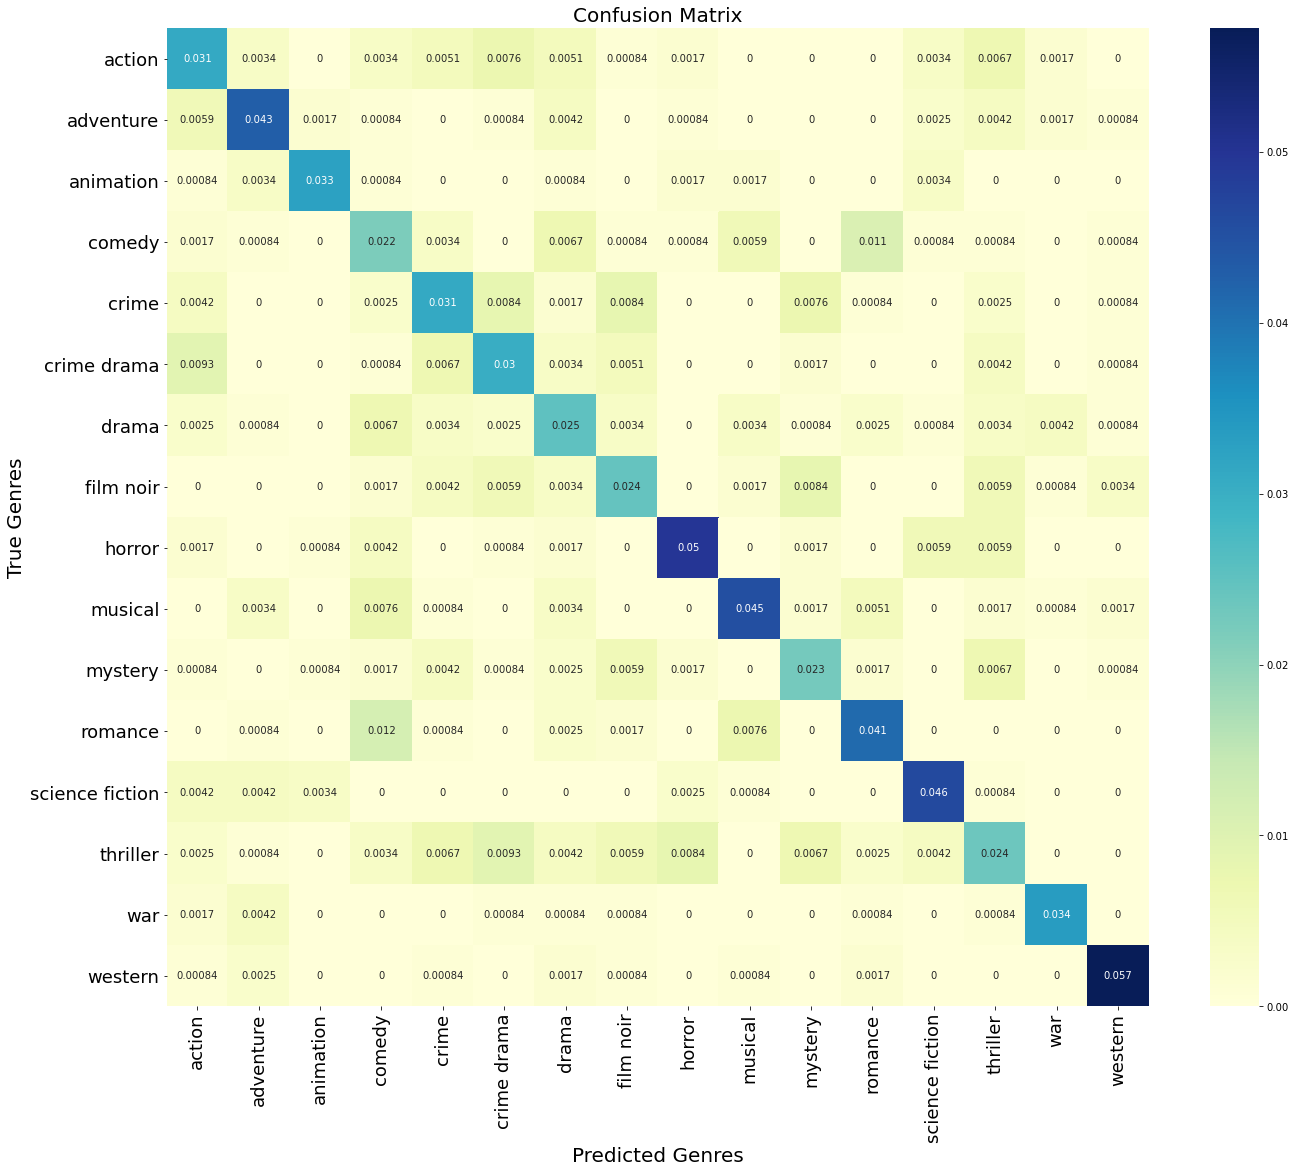

In [8]:
predicted_genres_encoded = list(map(lambda x: np.argmax(x), model_outputs))
predicted_genres = list(label_encoder.inverse_transform(predicted_genres_encoded))
eval_gt_labels = eval_df["Genre"].tolist()
class_labels = list(label_encoder.classes_)

plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_genres, eval_gt_labels, class_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap="YlGnBu")
ax.set_xlabel('Predicted Genres', fontsize=20)
ax.set_ylabel('True Genres', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_labels, rotation=90, fontsize=18)
ax.set_yticklabels(class_labels, rotation=0, fontsize=18)

plt.show()

## Prediction 🔮

In [9]:
for _ in range(100):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['Plot']
    true_genre = eval_df.iloc[random_idx]['Genre']

    # Predict with trained multiclass classification model
    predicted_genre_encoded, raw_outputs = model.predict([text])
    predicted_genre_encoded = np.array(predicted_genre_encoded)
    predicted_genre = label_encoder.inverse_transform(predicted_genre_encoded)[0]

    print(f'\nTrue Genre:'.ljust(16,' '), f'{true_genre}\n')
    print(f'Predicted Genre: {predicted_genre}\n')
    print(f'Plot: {text}\n')
    print("-------------------------------------------")



True Genre:     western

Predicted Genre: western

Plot: Sgt. Wade McCoy (Chuck Connors) deals with the Apache and rookie Lieutenant Jonathan Davenport (George N. Neise).

-------------------------------------------




True Genre:     war

Predicted Genre: action

Plot: In 1993, following the ousting of the central government and start of a civil war, a major United Nations military operation in Somalia is authorized with a peacekeeping mandate. After the bulk of the peacekeepers are withdrawn, the Mogadishu-based militia loyal to Mohamed Farrah Aidid declares war on the remaining UN personnel. In response, the U.S. Army deploys three of its special operations forces – 75th Rangers, Delta Force counter-terrorist operators, and 160th SOAR - Night Stalkers aviators – to Mogadishu to capture Aidid, who has proclaimed himself president of the country.
To consolidate his power and subdue the population in the south, Aidid and his militia seize Red Cross food shipments, while the UN forces are powerless to intervene directly. Outside Mogadishu, Rangers and Delta Force capture Osman Ali Atto, a faction leader selling arms to Aidid's militia. A mission is planned to capture Omar Salad Elmi and Abdi Hassan 



True Genre:     comedy

Predicted Genre: comedy

Plot: Timid milkman Burleigh Sullivan (Lloyd) works for the American company, Sunflower Dairies. Two drunk men try to chat up Mae, Burleigh's sister, and he chances by. In an ensuing brawl, Speed McFarland, the world middleweight champion, gets knocked out (but Burleigh never in fact threw a punch; he merely ducked to get out of the way of a punch which brought the champ down).
McFarland's boss, the crooked Gabby Sloan (Adolphe Menjou), decides to promote Sullivan in a series of fixed fights that will culminate in him being knocked out in a real fight with McFarland. Against all the odds, Sullivan triumphs and becomes world champion.

-------------------------------------------




True Genre:     crime

Predicted Genre: thriller

Plot: Irish nationalists plans to seize a security van to raise money for their movement. A photographer begins to investigate the raid, as one of his friends was murdered during it.

-------------------------------------------




True Genre:     film noir

Predicted Genre: crime

Plot: Clem Morgan, demobilised from the Royal Air Force and unemployed after the war, is drawn into the world of crime. His psychopathic crime boss Narcy (short for Narcissus) deals in the black market, transporting goods in coffins to his headquarters in a funeral parlour. Clem finds the activity harmless enough, until one day he finds drugs in the latest coffin. Clem objects and tells his girlfriend, Ellie, that he will quit after one last job that night, the looting of a warehouse. Narcy betrays him, triggering the burglar alarm while he is inside. Clem manages to get back in the car with Narcy and another member of the gang, Soapy, before they drive off. When Narcy orders Soapy to run down a policeman, Clem grabs the wheel in an unsuccessful attempt to save the man's life and the car crashes into a lamppost. Narcy knocks him unconscious and has him moved to the driver's seat before fleeing with Soapy. Inspector Rockliffe arrives 



True Genre:     comedy

Predicted Genre: comedy

Plot: The Heffley family attends a pool party at the local pool, where the family meets a former trouble-making friend of Rodrick who is now a model student after attending a military school known as Spag Union. Greg's father Frank thinks about enrolling Greg there.
Greg's summer starts off badly: Frank bans video games in anger at Greg's laziness, and his mother Susan starts a book club for all the boys in the neighborhood, but she does not see their books as real literature. Frank is also getting jealous of the neighbor's athletic kids, and after his video game ban, Susan forces Frank and Greg to bond with each other: their bonding activities end in disaster.
A few weeks later, Greg's best friend, Rowley Jefferson, takes Greg to the local country club, where his family are members of. Greg enjoys the lifestyle there and the fact that his crush, Holly Hills, teaches tennis there and he doesn't have to go to the book club.
Greg returns



True Genre:     crime drama

Predicted Genre: drama

Plot: Jenny (played by Susan Strasberg) is a deaf runaway who arrives in San Francisco's Haight-Ashbury district, searching for her brother Steve. She encounters the aptly named Stoney (Jack Nicholson) and his hippie band "Mumblin' Jim" in a coffee shop. The boys are sympathetic, especially when they discover that she is deaf and can only understand others through lip reading. They hide her from the police and help her look for her brother. She has a postcard from him which reads "Jess Saes: God is alive and well and living in a sugar cube". The band is approached by a promoter who arranges for them to perform at "the Ballroom", clearly the Avalon Ballroom or the Fillmore West.
Artist Warren (Henry Jaglom), who designs the psychedelic posters advertising the band, freaks out badly in his gallery, apparently on STP. He sees everyone, including himself, as walking dead and tries to cut off his own (to him festering) hand with a circu



True Genre:     thriller

Predicted Genre: thriller

Plot: Chyna Shepherd accompanies her friend Laura Templeton to her house for Thanksgiving dinner. A serial killer named Edgler Vess invades the house and kills Laura and her parents, as Chyna hides in the killer's vehicle. When Vess stops at a gas station, Chyna escapes and asks the two attendants to call the police.
Before she has time to explain, Vess returns and murders the two workers with a shotgun. Chyna then learns that he is holding a 14-year-old girl named Ariel hostage in his basement. She becomes determined to save Ariel and follows Vess back to his home. On the road she runs into a woman named Miriam and asks her to call the police. The woman does not realize that Chyna is serious about the murders until she sees the two dead bodies back at the gas station.
Unfortunately, she is hysterical on the phone with the police, telling them that they 'need to save Chyna and Ariel,' which the police interpret as the ramblings of 



True Genre:     drama

Predicted Genre: drama

Plot: Seven years after World War II, a 12-year-old boy named David (Ben Tibber) escapes a Stalinist labor camp in Bulgaria where he has spent his entire life. He sets out on a risky journey to Denmark, initially believing he is on an important mission to deliver a letter, but eventually discovering that the "mission" was to reunite him with his mother, of whom he has distinct memories. Along his journey, he faces danger, fear, loneliness, hunger, and encounters various people.
Johannes (Jim Caviezel), his friend and mentor in the camp, who prepares him for escape, is killed by a guard, leaving David to face escape on his own. David is helped by a guard to escape, who gives him a compass and tells him he must go southwest to Greece, take a boat to Italy and finally go north to Denmark, a peaceful and neutral country. The guard also tells him to trust no one. Since David was locked in a camp all his life, he has repressed feelings and tru



True Genre:     romance

Predicted Genre: musical

Plot: Three Russians, Iranov (Sig Ruman), Buljanov (Felix Bressart), and Kopalsky (Alexander Granach), are in Paris to sell jewelry confiscated from the aristocracy during the Russian Revolution of 1917. Upon arrival, they meet Count Leon d'Algout (Melvyn Douglas), on a mission from the Russian Grand Duchess Swana (Ina Claire), who wants to retrieve her jewelry before it is sold. He corrupts them and talks them into staying in Paris. The Soviet Union then sends Nina Ivanovna "Ninotchka" Yakushova (Greta Garbo), a special envoy whose goals are to go through with the jewelry sale and bring back the three men. Rigid and stern at first, she slowly becomes seduced by the West and the Count, who falls in love with her.
The three Russians also accommodate themselves to capitalism, but the last joke of the film is that one of them carries a sign protesting that the other two are unfair to him.

-------------------------------------------




True Genre:     musical

Predicted Genre: musical

Plot: Millionairess Mame Carson's (Jane Russell) oil empire spells trouble for her love life. Men are either after her fortune or afraid of it. Her money-shy fiancé Phil Barton (Craig Stevens) has just given her the brush off.
A disappointed Mame heads for Paris on the French Line's Liberté with friend and fashion designer Annie Farrell (Mary McCarty). She swaps identities with Myrtle Brown (Joyce MacKenzie), one of Annie's models, hoping to find true love incognito.
Aboard ship, she falls in love with French playboy Pierre DuQuesne (Gilbert Roland) who, unbeknownst to Mame, has been hired by her zealous guardian Waco Mosby (Arthur Hunnicutt) to keep the fortune hunters at bay. Pierre professes his love for Mame. Is he sincere or is this just a ploy to gain access to her millions? Silliness ensues interspersed with several musical numbers until Pierre's real intentions are revealed.

-------------------------------------------




True Genre:     adventure

Predicted Genre: war

Plot: Eve Tozer (Bess Armstrong) is a society heiress and flapper living the high-life in 1920s Istanbul. She needs to find her father, Bradley Tozer (Wilford Brimley), before he is officially declared dead or risk losing her inheritance to his scheming business partner, Bentik (Robert Morley). She only has 12 days. Eve hires World War I ace pilot Patrick O'Malley (Tom Selleck) and his aircraft. O'Malley is eager to take the job as he needs to leave town rather urgently himself. Eve, also an accomplished pilot, however, is determined to accompany him in his other aircraft, which causes the first of many arguments on the way from Istanbul and China.
Their journey in two biplanes (named "Dorothy" and "Lillian" after the famous Gish silent film star sisters[2]) through six countries leads them to finally find the eccentric Bradley Tozer in China, where he is helping a small village defend itself against a local warlord. O'Malley and Eve h



True Genre:     science fiction

Predicted Genre: science fiction

Plot: The movie opens with Dogen attacked by a "skybike" (a one-man, open-cockpit flying machine), piloted by a nomad. Dogen shoots down the bike and finds one of Syn's crystals on the pilot's body. Carved into the crystal is a symbol of a dead tree. Dogen next finds a murdered prospector, whose young daughter Dhyana (Kelly Preston) saw him killed by Baal (R. David Smith), Jared Syn's half-cyborg son. Baal sprayed the man with a green liquid that caused a nightmare dream-state, in which Syn appeared and executed him with a crystal. Dogen convinces Dhyana that it's his mission to find Syn and she joins him.
Dhyana takes Dogen to Zax (Marty Zagon) who tests the crystal and identifies it as a lifeforce storage device. Dhyana tells them about the ancient Cyclopians who once used such devices and says the only power against it is a magic mask located in their lost city. Zax affirms this and directs Dogen to find a prospect



True Genre:     science fiction

Predicted Genre: science fiction

Plot: On January 5, 1900, four friends arrive for a dinner at the London home of their inventor friend George, but he is not there. Suddenly, he arrives, bedraggled and exhausted, and begins to describe the strange experiences he has had since the group last met.
At their earlier dinner on New Year's Eve, George described time as "the fourth dimension" to David Filby, Dr. Philip Hillyer, Anthony Bridewell, and Walter Kemp. He shows them a small model time machine and asks a guest to press a tiny lever. The device disappears, validating his claim, but his friends remain unconvinced; their reactions vary from curiosity to frank dismissal.
George bids his guests a good evening, then heads downstairs where his full-size time machine awaits. He presses a lever and moves forward through time 17 years into the future to 1917. He meets Filby's son, James, who tells him of Filby's death in a War. Saddened, he resumes his journ



True Genre:     musical

Predicted Genre: romance

Plot: Berke Landers and his girlfriend Allison were the quintessential high-school couple who grew up together and eventually fell in love, but she breaks up with him immediately after the film begins. This leads to an opening musical number of "Love Will Keep Us Together" by Captain & Tennille, imagined by Berke. He seeks advice from his embarrassing parents Frank and Beverly Landers, who are hosts of a relationship advice show called Love Matters, but they don't help with the situation and constantly focus on his sex life and sexuality throughout the film. Allison then starts a relationship with Striker, a 'foreign' student who was once the lead singer of a boy band called the Swingtown Lads. When Allison and Striker audition for the school's upcoming musical, Berke desperately tries to win Allison back by also auditioning for the play, despite having no theatrical talent and having a busy schedule as a member of the basketball tea



True Genre:     horror

Predicted Genre: horror

Plot: The late Dr. Campbell was experimenting with vampire bat blood just before his death. Colleague Paul Beecher (Beal) finds a bottle of pills among Dr. Campbell's effects and takes them home. Dr. Beecher's daughter, Betsy (Lydia Reed), accidentally substitutes the vampire blood pills for her father's migraine tablets. As a result, the kindly Dr. Beecher starts having blackouts from the pills.
During a consultation with patient Marion Wilkins (Ann Staunton), Paul feels unwell and asks her to return the next day. The following morning, he receives a phone call notifying him that Marion has gotten progressively ill. When he goes to visit her, he finds her terrified by his presence, and she dies suddenly. On her neck, Paul finds two puncture wounds.
Worried about his recent blackouts, Paul returns to Campbell's lab where he speaks with his colleague, Will Beaumont (Dabbs Greer). Will tells Paul that Dr. Campbell's research involved reg



True Genre:     drama

Predicted Genre: drama

Plot: The film opens with a local man driving to the home of Lawrence and Darius, twin brothers who operate a local store. Upon entering the home, the man discovers Darius dead in his bedroom with Lawrence sitting on the couch unable to speak. Lawrence then walks to a neighboring property and shoots himself in the chest, which he survives. In the hospital, it is revealed that Darius committed suicide. Depressed and unable to return to the store he owns, Lawrence spends his days at the property he shared with his brother. Meanwhile, James, Darius' estranged pubescent son, steals Lawrence's gun and holds him at gunpoint for money to buy crack. After a failing to repay debts to his drug dealer, James and his mother, Marlee, are targeted in a drive-by assault. Unable to return home, Marlee confronts Lawrence about Darius leaving her and James many years prior and moves into Darius' vacant apartment. After she is fired from her job as a clean



True Genre:     war

Predicted Genre: war

Plot: Flagg and Quirt are veteran United States Marines sergeants whose rivalry dates back a number of years. Flagg is commissioned a Captain, he is in command of a company on the front lines of France during World War I. Sergeant Quirt is assigned to Flagg's unit as the senior non-commissioned officer. Flagg and Quirt quickly resume their rivalry, which this time takes its form over the affections of Charmaine, the daughter of the local innkeeper. However, Charmaine's desire for a husband and the reality of war give the two men a common cause.

-------------------------------------------




True Genre:     drama

Predicted Genre: comedy

Plot: Distracted just before the fight by the news that his mother has died, boxer Jimmy Nolan is defeated in the ring. As he and his sister Mary attend the funeral, Jimmy also deals with an injured arm from the fight.
At a nightclub Jerry Filmore owns, Jimmy meets dancer Adele, who is Filmore's romantic interest as well. A ticket taker at the door, Ralph Landon, takes $500 from the till and plants it on Jimmy, framing him. Jimmy goes to jail.
Ralph falls in love with Mary and confides to her that he owed $1,000 to Filmore and set up her brother on his behalf. Jimmy gets out of jail, accepts a fight and wins a $1,000 prize, settling Ralph's account with Filmore. It leads to a fistfight between the two men. Jimmy wins that one as well.

-------------------------------------------




True Genre:     crime drama

Predicted Genre: crime drama

Plot: The wife of politician David Stratton (John Forsythe) is away in San Francisco, visiting relatives there. Stratton comes home one night but not to an empty house—a young woman, Jody (Ann-Margret), is waiting inside.
Jody tells him a tale of woe, so David offers to help. But the truth is, she has just busted out of a juvenile detention home, where she stabbed a matron and started a fire. And she is far from alone, because two young men suddenly materialize to torment David, who is afraid of a public scandal that could end his career. If he tries to get away and contact the cops, Jody threatens to accuse David of rape. The young men and Jody enjoy a wild party, but also begin to quarrel until one is cut with a razor. They drive across the Mexico border, taking David along.
Jody and David elude them and end up in a Tijuana motel. When the punks return, a chase occurs and their car crashes, killing both of the young men. Jo



True Genre:     adventure

Predicted Genre: war

Plot: College football player Lefty Phelps (Ralph Graves) causes his school to lose the big game when he gets disoriented after a tackle and runs the wrong way. After being treated decently by gruff U.S. Marine Corps Sergeant "Panama" Williams (Jack Holt), a spectator, Phelps decides to enlist in the Marines himself. He is selected to attend pilot training school at Naval Air Station Pensacola, where Williams is a flying instructor. When Williams finally recognizes Lefty, he befriends him and takes him under his wing. On his first attempt at solo flight, however, Lefty is taunted about the football game by fellow recruit Steve Roberts (Harold Goodwin), and cannot take off, resulting in a crash. Panama rescues Lefty from the burning aircraft, suffering burns to his hands. Lefty is "washed out" by his squadron commander, Major Rowell (Alan Roscoe).
Lefty is taken to the base hospital, where he falls for Navy nurse Elinor Murray (Lila Lee



True Genre:     adventure

Predicted Genre: adventure

Plot: In 1821, a British sailing ship, the Becket, anchors on the New Zealand coast. Philip Wayne (Hawkins) and Paddy Clarke (Purcell), respectively First Mate and Bos'un, land to explore. They discover a Māori burial cave, but are captured by the local tribe. Accused of sacrilege, they manage to impress the tribesmen enough to be offered a trial by challenge, which Wayne succeeds in. The Māori chief, Hongi Tepe (Inia Te Wiata) is impressed enough to adopt Wayne, and allot him a portion of land. The sailors return to the ship.
Back home, they are set up by the corrupt Captain Bryce on charges of smuggling contraband and arrested. Found guilty, they manage to pay the heavy fine. Wayne, now married to Marion, returns to New Zealand with Clarke to start a colony.
A village grows slowly and a tenuous peace is established with the local Maori, although some remain hostile. Marion starts teaching English, and also Bible classes.
The Be



True Genre:     crime

Predicted Genre: crime

Plot: Inspector Hanaud is asked to investigate a murder in which a young woman is accused of murdering her wealthy employer in a Riviera mansion and then running away. She is innocent, but the villain is able to make her seem guilty. Hanaud uncovers the truth, that the murder was the result of a jewel robbery gone wrong.

-------------------------------------------




True Genre:     comedy

Predicted Genre: musical

Plot: Chuck Stephens is fooled by his sailor pals Swifty and Mike into believing (and betting on) that if he marries by his 27th birthday, he will inherit $25,000. With only days to go before his deadline, a frantic Chuck is taken to Aunt Navy's nightclub in San Pedro, California and introduced to singer Linda Hall, making a bad first impression.
Linda eventually grows more interested in Chuck, but ends up arrested after a bracelet he gives her as a gift turns out to be stolen. Chuck considers marrying other women rounded up by the guys, but realizes he loves Linda after all. He marries her after the deadline, but unexpectedly gets a $5,000 reward for recovering the stolen bracelet.

-------------------------------------------




True Genre:     adventure

Predicted Genre: adventure

Plot: Harry Quatermain (George Montgomery) is the son of Allan Quatermain who first set out on the quest for the source of Solomon's wealth, and he is determined to succeed where his father failed. He goes to Africa with his good friend Rick Cobb (David Farrar) and as they continue on their journey, Erica Neuler (Taina Elg) joins them. She is the daughter of a missionary who has been killed by a local tribe. Harry cannot hide his antagonism toward Erica. She is German, and Harry's mother was killed at sea by Germans in World War I.[3]

-------------------------------------------




True Genre:     horror

Predicted Genre: horror

Plot: A man who murders his wife is haunted by her, and eventually goes to his own death.

-------------------------------------------




True Genre:     crime

Predicted Genre: crime

Plot: Five men carry out an elaborate plan to rob a gold shipment from a San Francisco bound US mint train. To throw the police off the track, they split up and drive off in three different directions. Two of the gang's gold-laden trucks are captured by the police, but the third makes it all the way to LA where Eddie (Raymond) melts down the gold and disguises it as fittings for his luxury car. On the verge of getting away he is involved in a freeway accident.

-------------------------------------------




True Genre:     film noir

Predicted Genre: film noir

Plot: Pat Quaid, an alcoholic San Francisco widower, ends up in jail. His grocery-clerk son, Eddie, needs $25 to bail him out. When he can't borrow it, Eddie enters an amateur fight contest and wins it.
Julie Walsh is in love with Eddie, but her father disapproves of the Quaid family, particularly the boy's father, so he makes Julie stay away. Pat Quaid, once a promising prizefighter, urges his son to give it a try professionally. Eddie agrees on the condition that Pat quit drinking.
Eddie decides to adopt his dad's old ring name, Packy Glennon. To train him, the Quaids go to Bernie Browne, who also has had a problem with booze. Bernie's work with Eddie eventually leads to a fight with Al Gorski for the middleweight championship. Julie shows up, but Eddie angrily dismisses her. Pat explains that Julie's dad has recently committed suicide. Eddie chases after her.
Eddie wins the fight and becomes increasingly arrogant. He trains la



True Genre:     western

Predicted Genre: western

Plot: An ex-Confederate Army officer (Richard Boone) named Jim Lassiter, who has been out for revenge against Apache Indians who massacred his family, recovers a stolen U.S. Army repeating rifle from some Apaches he has killed; as the Apache have proven formidable with lesser weaponry, there is cause for concern should they become equipped with such superior firepower.
The U.S. Army arrests him, then offers Lassiter his freedom if he leads a small, clandestine scouting unit into Mexico consisting of an Army captain (Stuart Whitman), a Buffalo Soldier sergeant (Jim Brown), a knife-wielding Mexican prisoner (Tony Franciosa), and later an Apache woman warrior (Wende Wagner).
After blasting their way through bandits and Apaches, they discover Colonel Pardee, another former rebel soldier (Edmond O'Brien), has set up a new Confederate headquarters, and is selling guns to the Apaches, including the ones who slaughtered Lassiter's family.
Th



True Genre:     horror

Predicted Genre: horror

Plot: Lugosi plays a psychology professor by day who, secretly and under an assumed name, runs a Bowery soup kitchen by night called the Bowery Friendly Mission. Lugosi's character uses his soup kitchen as a means to recruit members of a criminal gang, of which he is also secretly the head. Throughout the film, one of Lugosi's henchmen, a doctor who seems to be an alcoholic drug addict, alludes to having plans for the corpses of henchmen Lugosi has had killed. Then, at the end of the film, these corpses are revealed to have been restored to life by the doctor. Lugosi's character meets his demise when the doctor leads the unwitting Lugosi into a basement room where the reanimated corpses attack him. Towards the end of the film, the male lead, played by John Archer, appears to be killed and mysteriously reanimated, in which state his girlfriend sees him. Then, in the film's final scene, he appears restored to his former health, and not l



True Genre:     horror

Predicted Genre: mystery

Plot: At the funeral of her husband Frank, wealthy widow Margaret DeLorca (Bette Davis), meets up with her identical twin sister, dowdy and downbeat Edith Phillips (also played by Davis), from whom she has been estranged for 18 years. The two return to DeLorca's opulent mansion, where they argue about their falling out over Margaret's marriage to DeLorca, who originally courted Edith but had an affair with Margaret. Margaret had forced Frank to marry her by telling him she was pregnant with his child. However, Edith finds out from Margaret's chauffeur (George Chandler) that the couple were childless, and becomes resentful, realising how Margaret had trapped Frank into marriage. While Margaret now enjoys a life of ease and wealth, Edith is struggling financially; her business, a cocktail lounge, is losing money and she is threatened with eviction for not paying her bills.
Later the same day, which is also the sisters' birthday, Edith r



True Genre:     comedy

Predicted Genre: romance

Plot: Kat Ellis (Debra Messing) is a single New Yorker who returns to her parents' house in London to be the maid of honor at her younger half sister Amy's (Amy Adams) wedding. The best man is none other than her former fiancé, who unexpectedly dumped her two years ago. Anxious about confronting him and eager to impress him, she hires suave escort Nick Mercer (Dermot Mulroney) to pose as her boyfriend.
Kat intends to make her former flame, Jeffrey (Jeremy Sheffield), jealous, but her plan backfires when Nick convinces everyone, including her, that they are madly in love. Kat then feels herself, too, falling for Nick as he slowly falls for her. The night before the wedding, Kat discovers Amy slept with Jeffrey when they were still together, and that Jeffrey dumped Kat because he believed he was in love with Amy. Nick had discovered this fact a day earlier, and when Kat finds that out, she feels betrayed from all sides, and puts Nick of



True Genre:     thriller

Predicted Genre: film noir

Plot: Art dealer Henri Landru becomes infatuated with burlesque performer, Odette, who already has a lover and is only interested in Landru for money. She tricks Landru into thinking her mother is sick and needs money for an important operation. Landru vows to raise the money to fund the operation.
Landru attempts to find furniture that he can sell. He meets a young widow, Vivienne, who is hoping to sell some vintage furniture. He quickly charms Vivienne but when he later discovers she has sold her furniture to somebody else they quarrel, resulting in Vivienne's accidental death. Landru is able to cover up the manslaughter, but when he is able to easily claim Vivienne's furniture as his own and sell it he realises he has found an easy way to make money. Landru adopts several aliases and charms several wealthy, middle-aged women one by one, wooing them into marriage before killing them, usually by drugging them and then stabbing th



True Genre:     romance

Predicted Genre: drama

Plot: Sam Lee (Barthelmess) is the only son of extremely wealthy Chinese merchant Lee Ying. Sam can pass as white. Lee Ying sends him to a prestigious university, where he studies hard. He is tolerated in white social circles, even though it is known there that he is Chinese, because of his money. One day, two fellow students talk him into a triple date, but the white girls are outraged when they find out that they are out with a "dirty yellow Chinaman". They pressure the two white men to make up a transparently fake excuse to leave. Insulted, Sam drops out of school.
He tells Lee Ying that he is going to travel on his own, without his father's financial support. He takes a lowly job aboard a ship and ends up working for a novelist named Bathurst because of his knowledge of Chinese. In the south of France, Sam meets Allana Wagner (Bennett), the spoiled daughter of an indulgent father.
Allana falls madly in love with Sam. Though Sam lov



True Genre:     war

Predicted Genre: war

Plot: In 1943, World War I veteran Jim Butler (Montagu Love), along with his daughter Nona (Inez Cooper) and their English servant and friend, Harry Adams (Ernie Adams), live on Sunday Island, a small island in the South Pacific. Their idyllic life is shattered when an air battle takes place over the island. One pilot bails out of his damaged aircraft while the other pilot manages to land.
A German pilot, Lt. Kurt Heiman (Henry Guttman) finds that the American pilot Allan Scott (Edward Norris) is unconscious, but before he is killed, Mona entreats Helman to bring the wounded American to her home. Butler is afraid that either pilot will contact their superiors about the valuable oil deposits on the island, so he takes control of the situation, confiscating the German's pistol and insisting that both antagonists agree to a truce.
Helman has a secret ally on the island, Captain Van Bronck (Robert Armstrong) and together, the two make plans to h



True Genre:     musical

Predicted Genre: romance

Plot: In New York City in the early 1950s, Jerry Biffle (Phil Silvers) is the star of the Blendo Soap Program. He has been invited to participate in an autograph-signing party for his new book at an important department store. Jerry meets Sally Peters (Judy Lynn), one of the department store models, and makes her part of his TV troupe. As part of his campaign to court Sally, Jerry gets Cliff Lane (Danny Scholl), the tenor of his TV company, to sing to her over the phone. When Sally and Cliff meet, they fall in love, with Biffle ignorant of the complications.
Biffle engineers a big publicity wedding between Cliff and "a girl," not knowing that Sally is the girl. To further complicate his life, Jerry learns that he is about to lose his sponsor. The publicity elopement between his girl and Cliff almost shatters his entire career and life.
When it seems that his whole world will cave in, Jerry's sponsor comes up with a new format for the



True Genre:     romance

Predicted Genre: romance

Plot: The plot offers a comic spin on adultery. When Greg crashes his sports car, doctor Evelyn comes to his rescue, and the two soon are engaged in an affair. Evelyn's workaholic husband learns about it from Greg's live-in girlfriend, scatterbrained television weather girl Stephanie, and the two begin to engage in a dalliance of their own. Complications arise when the two couples plan a clandestine weekend getaway at the same Acapulco resort.

-------------------------------------------




True Genre:     musical

Predicted Genre: musical

Plot: During "Operation Ice Cream" at a U.S. Navy reservation in the Arctic, buddies Danny Xavier Smith and Rico Ferrari are exempted from a swimming lesson in the icy water when their friend, Chief Boatswain's Mate William F. Clark, recruits them to bake a birthday cake for the commander. Bill explains that a planeload of replacements is due in, and if they impress the commander with the cake, they may be selected to go home. When Bill leaves them in the kitchen, Danny and Rico admit that neither one knows how to bake, and they come up with the idea to poke holes in another sailor's failed attempt at a cake, fill the holes with rum, then dress the whole thing up with candles and icing. The commander is delighted, but the cake combusts when he blows out the candles, and the three friends find themselves transferred to "Operation Mud Pie" in a snake-infested swamp.
Later, on a two-day shore leave in San Francisco, Bill goes to the nig



True Genre:     crime

Predicted Genre: crime

Plot: The film opens with a car plunging over a cliff in Italy. The killed driver is newspaperman Lewis Forrester. The woman with him is supposedly Alison Ford, an actress. But she wasn’t actually in the car and turns up later in England to try and solve what was in truth a murder to shut the newspaper man up, not an accident. She solicits the help of Forrester's brother, Tim, an artist. Then, as the story unfolds, a number of mysterious, unsolved questions keep emerging, along with two more murders and a suicide. And before it's over it has been learned that an international ring of diamond thieves is at the bottom of everything, that no less than four of the major characters are part of it, and that an independent blackmailer is at work as well.

-------------------------------------------




True Genre:     western

Predicted Genre: western

Plot: The Republic of Texas has just gained its independence from Mexico. Erastus "Deaf" Smith, who is a deaf mute, and his partner Johnny Ears are sent by President Sam Houston to stop general Morton, who plots against the annexation of Texas by the USA.
They find their contact McDonald and his family massacred by Morton and his men. McDonald’s daughter Hester is married to Morton, and when Smith convinces her of the truth, she helps them overhear a conversation where a German diplomat promises Morton new weapons.
They have a saloon fight with Morton's gang. At a brothel, Johnny recognizes a prostitute he saw bathing in a river, Suzie Q. Deaf pays so he can spend a night with her. Later he is jealous of her other customers, but when she suggests that they leave together using her money, he says that Deaf needs him. Later he refuses to go on with the dangerous mission because he is in love and hits Deaf.
Deaf steals dynamite in Morto



True Genre:     action

Predicted Genre: crime drama

Plot: Scarlett (Tatum O'Neal) is a hardened street kid who supports herself with prostitution and drug dealing. Facing charges of killing a client, Scarlett is brought to court. At court, she briefly encounters Tracy Freeman (Irene Cara). Tracy, a doctor's daughter, has been arrested for drug possession and resisting arrest. Tracy admits to using racial slurs against the white officer who arrested her, implying that he also used racial slurs toward her.
The two are seated in front of a judge along with other criminal defendants. One of the other defendants begins acting out in front of the judge. When the judge orders the bailiff to restrain her, the defendant slashes the bailiff's throat with a concealed weapon. Another defendant disarms another bailiff and a shoot-out begins.
Scarlett and Tracy, along with all the others in the courtroom, escape. The police, not knowing that Scarlett and Tracy were not involved in the shooting, 



True Genre:     action

Predicted Genre: drama

Plot: Alexander Villard is a former fencing champion who runs a highly competitive fencing school. One of his students describes him as "a freak who thinks he's living in the fourteenth century".[3]
Max Suba is an ex-convict who introduces himself as a fencing instructor. Villard initially gives him a job as a janitor. With time, Suba recovers his lost form and shows that he can fence. Villard has Suba spar with an ambitious student to demonstrate a point. Villard is "arrogant but not unkind",[4] and eventually gives Suba a chance to teach, assigning him the beginning students.
While Villard takes a ruthless approach, encouraging a student to injure an opponent to win, Suba takes a subtler approach, encouraging students to turn their own weaknesses into strengths. Following this advice, one of Suba's beginning level students scores against Villard's prize fencer during an in-school competition. Flashbacks further develop the conflict by



True Genre:     musical

Predicted Genre: musical

Plot: The story is told in a series of vignettes and musical numbers that serve to show events in flashback. Our narrative link is New York radio star Jed Potter, who once was a renowned Broadway hoofer. The conceit is that he is on the air, telling his life story, which does not yet have an ending.
The tale starts just after World War I and centers on two men who became friends in the Army: rising dancer Potter and business-minded Johnny Adams. While hardworking Potter dreams of stardom, the more laid-back and less disciplined Adams has hopes of becoming a successful nightclub owner.
In time, dancer Potter falls in love with a band singer, Mary O'Hara. He takes Mary to Adams' nightclub, where she takes a shine to Adams. Potter warns Mary that his old buddy is not the marrying kind, but she marries Adams. The union is not a happy one, despite the birth of a child. Adams' nightclub business is anything but a resounding success, and it



True Genre:     film noir

Predicted Genre: comedy

Plot: Slob (Marvin), the leacherous short-order cook at the seaside greasy-spoon diner of sarcastic war veteran George (Wynn), lusts after sexy waitress Kotty (Moore). Also interested in Kotty is a scientist (Lovejoy), who spends the better part of his free time at the diner's counter. He works down the highway at a top-secret military base. As it turns out, Slob isn’t just a short-order cook. He’s also a spy using the diner as a home base for smuggling nuclear secrets out of the country through a connection with one of the diner’s regulars.

-------------------------------------------




True Genre:     adventure

Predicted Genre: adventure

Plot: A World War I American troopship is torpedoed, and many soldiers are trapped below the deck. Jericho Jackson (Robeson), a medical student drafted into the war, heroically saves the trapped men, in defiance of his superior’s orders to abandon ship, but accidentally kills the officer in the melee. Despite his heroism, Jericho is court-martialed for refusing orders. Embittered, he escapes. Captain Mack is held responsible for his escape and court-martialed.
Jericho ends up in North Africa, where he meets the Tuareg people. When he uses his medical skills to heal the sick, the Tuareg welcome Jericho into their tribe, and he marries and raises a family. He eventually becomes the Tuaregs' leader. He leads his people to victory over rivals and brings peace and unity to the region through which the Tuareg trek annually to trade for salt. When an anthropology film crew’s coverage of the salt trek is shown in London, Captain Mack spo



True Genre:     thriller

Predicted Genre: drama

Plot: The story centers around a teenage girl named Sheri, whose desire is to join the Pittsburgh Ballet Theatre. At 17, fulfilling her dream, she discovers she has a rare blood disease. Sheri rebels against her father and God, causing her father to seek to keep his daughter close to God, to soften her heart, and to live out her dream before dying, all while he anguishes over losing his daughter so young. While praying to God to ask for strength and clear direction for her remaining days, God blesses Sheri so she is able to bring people to Christ against their will.[5]

-------------------------------------------




True Genre:     musical

Predicted Genre: musical

Plot: Theater producers (Horton and Sakall) staging a wartime charity program, only to have the production taken over by their egotistical star (Eddie Cantor). Meanwhile, an aspiring singer (Dennis Morgan) and his songwriter girlfriend (Joan Leslie) conspire to get into the charity program by replacing Cantor with their look-alike friend, tour bus driver Joe Simpson (Eddie Cantor).
Many of Warner Brothers's stars performed in musical numbers, including several who were not known as singers. The show features the only screen musical numbers ever done by Bette Davis, Errol Flynn, Olivia de Havilland, and Ida Lupino.

-------------------------------------------




True Genre:     romance

Predicted Genre: romance

Plot: As summarised in a film publication,[4] Georgette Verlaine (Duke) is a favourite stage actress that Dr. John Longden (Buckler), who is in love with her, persuades to recuperate in the country as her life is ruining her health. He selects a pretty place called "Crooning Water" where she stays with Horace Dornblazer (Newall), his wife Rachel (Dibley), and their three children. The fact that there is one man who does not fall for her smiles drives her to try and win the admiration of Horace. When she finally gets him where she wants him, she leaves and returns to London. Horace leaves his family and follows her to the city, but she tells him that she did not love him but only admired him for the things he stood for: honour, fidelity, etc. Georgette starts her gay life anew and Horace goes back to his family where he is forgiven. The actress soon tires of her frivolous life and returns to Crooning Water, where she too is forgiven, 



True Genre:     musical

Predicted Genre: musical

Plot: Frustrated singers Hannah Holbrook, Joyce Campbell and S. F. "Foxy" Rogers return dejectedly to New York on a bus, their out-of-town engagement in Vermont, arranged by small-time promoter Lew Conway, having been a huge flop.
Nancy Peterson, another passenger on the bus, mistakenly believes Dan Carter has stolen her suitcase. It turns out both are entertainers. They end up with each other's bags, then become better acquainted after the mix-up.
The conniving Lew represents Dan and tries to get him to take the same bad gig the girl singers just left. Lew also meets a couple of delicatessen owners, Leo and Harry, who might have money to invest in his performers' careers. The agent has an impersonator, Glendon, pretend to be the producer of bandleader Bob Crosby's television program.
Everybody excitedly believes that Lew has booked them on the TV show. Lew continually tries to get in to see Crosby's actual producer, totally in vain.



True Genre:     film noir

Predicted Genre: film noir

Plot: As newspaper editor Jim Austin prepares his testimony before the Committee, the story flashes back to the events which led to his testifying.
Austin is driven to investigate corruption after Clyde Nelson, a local private detective, working on an apparently harmless divorce case, discovers the existence of a big-time gambling syndicate operating with the consent of the city fathers, the local police, and the respectable elements of the community. Nelson is killed in a hit-and-run which appears to be an accident. Austin thinks otherwise because he is harassed by police when he looks into the PI's death.

-------------------------------------------




True Genre:     romance

Predicted Genre: comedy

Plot: Lambert T. Hunkins (Frank McHugh) works at a linoleum company. When his boss, Oxnard O. Parsons (Ferris Taylor), gives him a raise from $30 a month to $40, his girlfriend Violet's (Jane Wyman) mother, Mrs. Coney (Cora Witherspoon), decides that it is time for the two to get married. Lambert is too meek to object.
They go to an auction to buy some furniture, but when he sees a statue that resembles socialite Iris Mabby (Diana Lewis), the woman he adores from afar, he buys it, over the Coneys' objections. As Lambert is leaving, Iris's father, Senator Mabby (Berton Churchill), tries to buy the statue from him, but Lambert refuses to sell at any price. Their bargaining attracts the attention of a street reporter (John Ridgely), and the story of the humble office worker turning down a large sum of money gets into the media. The senator rushes off before he can be recognized. It turns out that Senator Mabby is mounting a public campai



True Genre:     thriller

Predicted Genre: thriller

Plot: In 1993, alcoholic advertising executive, Joe Doucett, becomes intoxicated and before passing out, sees a woman with a yellow umbrella. When he wakes, he finds himself locked within a hotel room. His unseen captors provide him with food and hygiene items, but do not explain why he is captive. Joe sees a news report that says his ex-wife Donna was raped and murdered and he is the prime suspect, while their infant daughter Mia was adopted.
Over the next twenty years, Joe works himself into shape, compiles a list of all those who would want to imprison him, and writes letters to eventually give to Mia. One day, he sees an interview with Mia, who says she would forgive her father if she ever saw him.
Joe is drugged shortly thereafter, and wakes to find himself outside with a cell phone and a small amount of money. He spots the woman with the yellow umbrella and gives chase, but ends up running into Marie Sebastian, a nurse that o



True Genre:     musical

Predicted Genre: comedy

Plot: In the late summer of 1957, in the West Side's Lincoln Square neighborhood in Manhattan, there is tension between a white American gang, the Jets, led by Riff Lorton, and a Puerto Rican gang, the Sharks, led by Bernardo Nunez. After a brawl erupts, Lieutenant Schrank and Officer Krupke arrive and break it up. The Jets decide to challenge the Sharks to a rumble at an upcoming dance for neighborhood control.
Riff decides that his best friend Tony Wyzek, the co-founder of the Jets who left the gang, should join them for the rumble. Riff invites Tony to the dance, and Tony is uninterested, but eventually agrees to come. He tells Riff that he senses something important will happen in his life, which Riff suggests could be related to the dance.
Bernardo's younger sister, Maria, tells her best friend and Bernardo's girlfriend, Anita Palacio, with whom she works at a bridal shop, how excited she is about the dance as they work on alteri



True Genre:     adventure

Predicted Genre: adventure

Plot: The plot of the film reprises that of the 1932 version, with James Parker (Douglas) Harry Holt (Danova) and Parker's daughter Jane (Barnes) on an expedition in Africa in which they encounter Tarzan, a wild man raised by apes. Various adventures ensue.

-------------------------------------------




True Genre:     mystery

Predicted Genre: musical

Plot: Tillie Whim (ZaSu Pitts), a timid stage assistant to The Great La Salle (William Gaxton) in a small mentalist act playing a Vaudeville theater, is harassed, bullied, and undermined by the act's co-star, primadonna Lottie (Tamara Geva). When Lottie finally attempts to fire Tillie after a performance, La Salle fires Lottie instead.
The remaining troupe are then hired backstage by an audience member (Bruce Cabot) to debunk another mentalist, whom he accuses of exploiting his friend, a grief-stricken woman who has recently lost her husband in a plane crash. Tillie is promoted to Lottie's old role as medium, but unexpectedly deviates from the script when the spirit of the departed tells her that the plane crash was murder.

-------------------------------------------




True Genre:     science fiction

Predicted Genre: science fiction

Plot: Using a spaceship furnished with wooden tables and rolling chairs, a "scientific expedition" to the Moon encounters a race of Cat-Women, the last eight survivors of a two-million-year-old civilization. Residing deep within a Moon cave, where they have managed to maintain not only the remnants of a breathable atmosphere and Earth-like gravity but also a pair of gigantic spiders, the Cat-Women sport black unitards, beehive hairstyles, and elaborate cosmetics. Realizing that the remaining air in their cave will soon be gone, the Cat-Women plan to steal the expedition's spaceship, migrate to Earth, and in the words of the Cat-Women's queen, Alpha (Carol Brewster), "We will get their women under our power, and soon we will rule the whole world"!
Through the use of their telepathic ability, the Cat-Women have been subliminally controlling Helen Salinger (Marie Windsor), the mission navigator and only female member of 



True Genre:     war

Predicted Genre: war

Plot: In May 1942, an Allied base on Java is bombed by Japanese aircraft, with another attack expected the next day. With only one working fighter and five American pilots who all volunteer to fly it, Dutch commander Major Eichel (Steven Geray) chooses George Collins (Franchot Tone) because he has come up with a daring plan: attach a bomb rack to the fighter to bomb the Japanese aircraft carrier from which the attack came. After George takes off, Eichel asks the other pilots to tell him about George. Flashbacks stories of his civilian life before the war are interleaved with radio broadcasts from George.
Four years earlier, George is working his way through law school and is at the top of his class. He takes Freddie Andrews (Marsha Hunt) to an empty lot in the country, where he proposes and tells her that he has bought the land to build their home. She accepts.
At first, they are happy, but then his friend and fellow lawyer Vito S. Alessandr



True Genre:     musical

Predicted Genre: romance

Plot: In New York City in the early 1950s, Jerry Biffle (Phil Silvers) is the star of the Blendo Soap Program. He has been invited to participate in an autograph-signing party for his new book at an important department store. Jerry meets Sally Peters (Judy Lynn), one of the department store models, and makes her part of his TV troupe. As part of his campaign to court Sally, Jerry gets Cliff Lane (Danny Scholl), the tenor of his TV company, to sing to her over the phone. When Sally and Cliff meet, they fall in love, with Biffle ignorant of the complications.
Biffle engineers a big publicity wedding between Cliff and "a girl," not knowing that Sally is the girl. To further complicate his life, Jerry learns that he is about to lose his sponsor. The publicity elopement between his girl and Cliff almost shatters his entire career and life.
When it seems that his whole world will cave in, Jerry's sponsor comes up with a new format for the



True Genre:     musical

Predicted Genre: musical

Plot: In Los Angeles, popular songwriter Steve Elliott (Red Skelton) prepares to marry Caroline Brooks (Esther Williams), who has pledged to give up her job as a college swimming instructor once she has wed. Likewise, Steve plans to quit his songwriting career, even though New York producer George Adams (Basil Rathbone) has already hired him to write new songs for a water ballet show.
When George overhears Steve discussing his "retirement" with Caroline, he vows to prevent the marriage and enlists Maria Dorango (Jacqueline Dalya), an aspiring actress posing as a Latin-American singer, to help him. Moments after a justice of the peace pronounces the redheaded Steve and Caroline man and wife, Maria rushes in, claiming that Steve is her husband and the father of her three redheaded children, which she has paraded in at that moment. Although Steve pleads his innocence, Caroline storms off in a rage and returns to her teaching post at Vic



True Genre:     western

Predicted Genre: film noir

Plot: With her husband in a Texas jail, sultry Violet Barton joins her sister Janet in a border town called La Mirada, where she seduces wealthy newspaperman Johnny Hale into marrying her. Johnny is unaware Violet is a bigamist or that Janet was in love with him.
Johnny's best friend, gambler Gregg Delaney, had been the object of Violet's affections at first before she discovered Johnny was rich. Vaan gets out of jail and tracks Violet down, threatening her with blackmail unless her new husband pays him. Vaan is murdered by Violet, who lets Johnny take the rap. Sheriff Bill Howard places him under arrest.
Johnny and Gregg each suspect the other of killing Vaan, not realizing it was Violet all along. Gregg helps spring Johnny from jail, then flees with Violet after she finally confesses to her various sins. Howard and his posse purse the fugitives and kill them both.

-------------------------------------------




True Genre:     drama

Predicted Genre: drama

Plot: When art dealer Madeleine (Embeth Davidtz) travels from Chicago to North Carolina to pursue a local, self-taught painter (Frank Hoyt Taylor) for her outsider art gallery, she takes the opportunity to meet and stay with the family of her new husband George (Alessandro Nivola), who live close by.
There is his mother Peg (Celia Weston); his reserved, contemplative father Eugene (Scott Wilson); and his sullen, resentful, twenty-ish brother Johnny (Benjamin McKenzie) who, although married, lives at home. He is studying for his high school equivalency certificate while working at Replacements, Ltd. as an order processor. Johnny married his now pregnant wife Ashley (Amy Adams) before either of them finished high school. Relations between Johnny and Ashley are strained, with Ashley believing that a baby will solve their marital problems.
Madeleine and George stay in the expected baby's nursery, and Madeleine becomes friends with Ashley, wh



True Genre:     action

Predicted Genre: action

Plot: Honorably discharged Army Ranger Cameron Poe is convicted of manslaughter after killing a drunken man who tried to attack his pregnant wife Tricia and imprisoned for ten years, communicating with his newborn daughter Casey through letters. Eight years later, he is paroled and takes a flight to Alabama on board the Jailbird, a Fairchild C-123 Provider converted into a flying prison transport. He is accompanied by his diabetic cellmate and friend Mike “Baby-O” O’Dell, who is being transferred. The flight is overseen by U.S. Marshal Vince Larkin, who is approached by DEA agents Duncan Malloy and Willie Sims, the latter planning to go undercover to get information from drug baron Francisco Cindino, who is to be picked up on route.
A number of inmates are being transferred to a new supermax prison, including mass murderer William "Billy Bedlam" Bedford, rapist John “Johnny 23” Baca, Black Guerrilla Family member Nathan “Diamond Dog” J



True Genre:     horror

Predicted Genre: horror

Plot: A man (Garrick Dowhen) in a white Ford van gets out and stabs his wife on the portico of a house. Before she dies, she gives her baby to Heather (Kerry Remsen) and urges her that he must be kept safe, knowing that his father will try to kill him. The case is followed by Detective Kowalski (Douglas Rowe), an off-beat, seedy looking detective. Kowalski later finds out the killer is in solitary confinement in the state mental facility but is somehow leaving his body in spirit and is under an Ancient Egyptian curse which gives him a need to kill his baby to be "King of the Forest" for another year. Kowalski later visits a specialist seeking advice on how to confront the Ancient Egyptian spirit and curse. Carol (Michele Little), a friend of Heather with a love of recording sounds, spots the white van following her in her pickup truck and becomes suspicious. She informs her love interest Bobby (Michael Wyle) of her fears and he dismiss



True Genre:     animation

Predicted Genre: animation

Plot: On Bird Island, an island inhabited by happy flightless birds, the reclusive Red is sentenced to an anger management class after his temper causes a "premature hatching" of a customer's egg. Resentful, Red avoids getting to know his classmates Chuck, Bomb, and Terence, as well as the class's instructor Matilda. One day, a boat docks at the island's shore containing green-colored pigs, and their captain Leonard, who claim to be peaceful explorers bringing offerings of friendship. The pigs are accepted on the island and introduce the birds to innovative technologies such as slingshots and helium balloons.
More pigs arrive and seemingly adjust to the birds' society, but Red soon becomes suspicious of their motives, as they slowly overwhelm the island. He recruits Chuck and Bomb to help him find Mighty Eagle, a giant bald eagle said to be the protector of the island, and the only bird that can fly, but who has not been seen for



True Genre:     crime drama

Predicted Genre: crime drama

Plot: Vincent Karbone is a leading construction magnate in Philadelphia and a suspected leader of one of the city's most notorious criminal gangs. Several of his thugs are on trial, and the key witness is Michael, a mild-mannered judo instructor with a wife and kids. Karbone will stop at nothing to keep the muscles of his organization out of prison, including striking at Michael's family to keep him from testifying.
The instructor Michael McBain (Bo Svenson) witnesses a murder, but he offers to testify against the thugs working for construction manager Vincent Karbone (John Colicos). Despite being placed in the witness protection program, Michael and his large extended family are soon targeted by Vincent's men. Though some of Vincent's goons are sent to prison, the attacks against Michael continue. With the police unable to help, he is forced to turn to violent measures to protect himself.
The Mafia is bent on revenge against



True Genre:     crime

Predicted Genre: crime drama

Plot: Car thief Dick Kanipsia gets a parole from a penitentiary. He intends to go straight, but first he goes directly to see an old friend Harry Moss, only to be shocked to see Harry get shot. Harry's dying words tell Dick to find Barry Fenaka, a guy who supposedly knows where to find a stash of stolen cash that Harry has hidden. Instead of dying slowly, Harry blows himself up with dynamite. As Dick flees the scene, a black van lurks in the trees.
Dick hitches a ride with Kitty Kopetzky, who starts out as a friendly free spirit, then turns into a nut case who robs a diner where she and Dick go to eat. Dick flees during her robbery and catches a passing bus.
Fenaka turns out to be a small-time bandleader. He explains to Dick that he and Harry embezzled $320,000, and paid a man named Palmer to stash it for them. He and his wife take Dick to go get the money. They travel by car, with an Air Stream Land Yacht in tow. At Palmer's offic



True Genre:     western

Predicted Genre: western

Plot: Two old friends, Matt Morgan (Kirk Douglas) and Craig Belden (Anthony Quinn), now find themselves on opposite sides of the law. Belden, a rich cattle baron, is the de facto ruler of the town of Gun Hill. Morgan is a U.S. Marshal living in another town with his Native American/Indian wife (played by Ziva Rodann) and young son, Petey.
Two young drunken cowboys rape and murder Morgan's wife while she is returning with their son from a visit to her father. The boy escapes on one of the killers' horses, bearing a distinctive, fancy saddle.
Morgan sets off to find the killer. His one clue is the saddle, which he recognizes as belonging to Belden. Assuming it was stolen from his old friend, Morgan travels to the town of Gun Hill to pick up the trail, but once there he quickly realizes that Belden's son Rick (Earl Holliman) is the killer.
Belden refuses to turn over his son, forcing Morgan to go against the entire town. He vows to capt



True Genre:     war

Predicted Genre: film noir

Plot: During the Nazi occupation of Czechoslovakia, surgeon Dr. Franticek Svoboda (Brian Donlevy), a Czech patriot, assassinates the brutal "Hangman of Europe", Reichsprotektor Reinhard Heydrich (Hans Heinrich von Twardowski), but his getaway car is discovered and therefore his planned safe house must reject him. When a woman he doesn't know, named Mascha (Anna Lee), deliberately misdirects German soldiers close to finding him, he seeks her home as an alternative safe house. This turns out to be the home of her father, history professor Stephen Novotny (Walter Brennan), whom the Nazis have banned from teaching. This plan works. But because the assassin now can't be found, the Nazi leaders in Prague decide to create an incentive for him to turn himself in or for others to do so. They arrange–with the help of fifth-columnist Emil Czaka (Gene Lockhart), a wealthy brewer–for 400 citizens, including Professor Novotny, to be executed, forty 



True Genre:     science fiction

Predicted Genre: science fiction

Plot: Evil Moon robot Ro-Man Extension XJ-2 (Barrows), referred to as just Ro-Man, has seemingly destroyed all human life on Earth with a Calcinator death ray, all except for eight humans that remain alive. The survivors are an older scientist (John Mylong), his wife (Selena Royle), his two daughters, his young son Johnny (Gregory Moffett), his assistant, and two space pilots that shortly take off in a spaceship for an orbiting space platform. All eight have now developed an immunity to Ro-Man's death ray, having received an experimental antibiotic serum developed by the scientist.
Ro-Man must complete the destruction of all humans, even if it means his physically killing them one by one, before his mission to subjugate the Earth is complete. After fruitless negotiations, Ro-Man, with a laser in hand, destroys the spaceship headed for the orbiting platform, killing the two pilots aboard. He later strangles the younges



True Genre:     action

Predicted Genre: crime drama

Plot: On Christmas Eve, NYPD detective John McClane arrives in Los Angeles, intending to reconcile with his estranged wife, Holly, at the Christmas party of her employer, the Nakatomi corporation. McClane is driven to the party by Argyle, an airport limousine driver. While McClane changes clothes, the party is disrupted by the arrival of a German terrorist, Hans Gruber, and his heavily armed team: Karl, Tony, Franco, Theo, Alexander, Marco, Kristoff, Eddie, Uli, Heinrich, Fritz, and James. The group seizes the tower and secures those inside as hostages except for McClane, who slips away, and Argyle, who gets trapped in the garage.
Gruber interrogates Nakatomi executive Joseph Takagi for the code to the building's vault and reveals that he plans to steal $640 million in bearer bonds, with terrorism merely a distraction. Takagi refuses to cooperate and is murdered by Gruber. McClane secretly watches, but accidentally gives himself a



True Genre:     horror

Predicted Genre: horror

Plot: The late Dr. Campbell was experimenting with vampire bat blood just before his death. Colleague Paul Beecher (Beal) finds a bottle of pills among Dr. Campbell's effects and takes them home. Dr. Beecher's daughter, Betsy (Lydia Reed), accidentally substitutes the vampire blood pills for her father's migraine tablets. As a result, the kindly Dr. Beecher starts having blackouts from the pills.
During a consultation with patient Marion Wilkins (Ann Staunton), Paul feels unwell and asks her to return the next day. The following morning, he receives a phone call notifying him that Marion has gotten progressively ill. When he goes to visit her, he finds her terrified by his presence, and she dies suddenly. On her neck, Paul finds two puncture wounds.
Worried about his recent blackouts, Paul returns to Campbell's lab where he speaks with his colleague, Will Beaumont (Dabbs Greer). Will tells Paul that Dr. Campbell's research involved reg



True Genre:     horror

Predicted Genre: horror

Plot: Troubled young Jenny (Susan Penhaligon) enters the confessional of her local church, and bares her soul to elderly priest Father Meldrum (Anthony Sharp). Apparently obsessed with her, Meldrum begins to stalk the distressed Jenny and blackmail her with a tape recording of her confession. Seeing himself as the dispenser of "divine justice", Meldrum tortures his victims with guilt, murdering those in his way with such diverse means as incense burners and poisoned holy wafers.

-------------------------------------------




True Genre:     thriller

Predicted Genre: musical

Plot: In 1952 Czechoslovakia, circus man Karel Cernik struggles to keep his beloved Cirkus Cernik together, which belonged to his family before being nationalized by the Communist government. The government allows Cernik to manage the circus, but he grapples with deteriorating conditions in the circus, loss of his workers to the state, and tension with his willful daughter Tereza, and his young second wife Zama, whom everyone suspects of being unfaithful. Cernik wants to end a budding romance between Tereza and roustabout Joe Vosdek, who has been with the circus for only a year.
Cernik is interrogated at the headquarters of the S.N.B. state security in Pilzen on why he is not performing the Marxist propaganda acts dictated by the government. Cernik explains that the skits were not funny, and that audiences prefer his usual act. The S.N.B. chief orders him to resume the required act, and to dismiss a longtime trouper who calls hersel



True Genre:     action

Predicted Genre: action

Plot: In the city of New Orleans, hitman Jimmy Bobo and his partner Louis Blanchard kill a corrupt former WDCPD policeman, Hank Greely, although Bobo leaves a prostitute, Lola, alive. Later, at a bar, Blanchard is murdered by another hitman, Keegan, who also attempts to kill Bobo but fails.
Washington, D.C., Detective Taylor Kwon arrives in New Orleans to investigate his former partner's death and meets Lieutenant Lebreton, who informs him Lola confirmed Greely was assassinated. Kwon goes to the morgue, and, after seeing Blanchard's body and finding out who he is, he deduces that Blanchard and Bobo killed Greely. Meanwhile, Keegan meets with his employer, Robert Morel, and Morel's lawyer Marcus Baptiste. Baptiste reveals that Greely tried to blackmail Morel, and provided local mobster Baby Jack with a file detailing Morel's illegal operations. Keegan later kills Baby Jack and his men and retrieves the file.
Kwon meets Bobo in a bar and



True Genre:     mystery

Predicted Genre: film noir

Plot: At his uncle's newspaper where Larry Elliot (Jack Haley) works as a reporter specializing in chess, he is known to miss out on bigger stories to cover more trivial events of minor interest. Confronted with an ultimatum if he wants to keep his job, Larry is assigned to cover a big harvest festival held at a winery in Grape City.
Larry begins with getting off the bus at the wrong stop, Grape Center instead of Grape City. He has brought along his girlfriend Sally Warren (Ann Savage), who deals in antiques. Accidents rarely come alone, and the man sitting next to Larry on the bus is found murdered, holding a chess piece in his hand when the police find him. Of course Larry, who is a chess expert, is blamed for the killing.
All the bus passengers are held in custody at Grape Center awaiting the sheriff to start the murder investigation. Before he arrives, Sally finds an set of antique chess pieces she wants to acquire, and involve



True Genre:     science fiction

Predicted Genre: horror

Plot: Sir Geoffrey Radcliffe (Vincent Price) is sentenced to death for the murder of his brother Michael, a crime he did not commit. Dr. Frank Griffin, the brother of the original invisible man (named John instead of Jack), injects the prisoner with an invisibility drug. As Radcliffe's execution nears, he suddenly vanishes from his cell. Detective Sampson (Cecil Kellaway) from the Scotland Yard guesses the truth while Radcliffe searches for the real murderer before the drug causes him to go insane.
The Radcliffe family owns a mining operation. The recently promoted employee Willie Spears (Alan Napier) is promoted within the company, stirring Radcliffe's suspicions. After forcing Spear's car off the road, Spears is scared into revealing that Richard Cobb (Sir Cedric Hardwicke), Radcliffe's cousin, is the murderer. After a confrontation, a chase scene ensues during which Radcliffe is struck by a bullet from Sampson. Cobb is kill



True Genre:     crime

Predicted Genre: crime

Plot: A Scotland Yard detective pursues a murderer aboard a Paris bound Hercules plane. The murderer is disguised, making every passenger a suspect.[3]

-------------------------------------------




True Genre:     film noir

Predicted Genre: thriller

Plot: Chuck Scott (Robert Cummings) is a World War II veteran who is now a penniless drifter in Miami tormented by bizarre dreams. After finding a wallet and showing his honesty by returning it to Eddie Roman (Steve Cochran), a vicious gangster, he is hired by Roman to be his driver. Roman tests his new driver, whom he nicknames 'Scotty,' by assuming control of his car from the back seat. Unbeknownst to Scotty, Roman has an accelerator installed in the rear passenger compartment so that he can "take over" the vehicle whenever he wants. This bizarre trick unnerves his new driver as well as Roman's right-hand man, Gino (Peter Lorre).
Roman reveals himself as a tough gangster by killing any competition, and even locks his wife, Lorna (Michèle Morgan), in her room every night to control her. Lorna goes for a drive every night at 9:30 pm, and one day she asks Scotty to take her to Havana, Cuba in exchange for $1,000. He consents and re



True Genre:     science fiction

Predicted Genre: science fiction

Plot: On January 5, 1900, four friends arrive for a dinner at the London home of their inventor friend George, but he is not there. Suddenly, he arrives, bedraggled and exhausted, and begins to describe the strange experiences he has had since the group last met.
At their earlier dinner on New Year's Eve, George described time as "the fourth dimension" to David Filby, Dr. Philip Hillyer, Anthony Bridewell, and Walter Kemp. He shows them a small model time machine and asks a guest to press a tiny lever. The device disappears, validating his claim, but his friends remain unconvinced; their reactions vary from curiosity to frank dismissal.
George bids his guests a good evening, then heads downstairs where his full-size time machine awaits. He presses a lever and moves forward through time 17 years into the future to 1917. He meets Filby's son, James, who tells him of Filby's death in a War. Saddened, he resumes his journ



True Genre:     horror

Predicted Genre: horror

Plot: In 2004, Broadway diva Kylie Swanson opened the musical The Haunting of the Opera (a reference to real-life musical The Phantom of the Opera) to a packed audience. However, that same night, she was murdered backstage by an unknown assailant wearing the mask of the play's villain, Opera Ghost. 10 years later in the present-day, Kylie's children Camilla and Buddy have grown up raised by Roger McCall, a former lover of Kylie's and the producer of a musical theater summer camp on the brink of bankruptcy. When Camilla hears that the camp will be producing a kabuki version of The Haunting of the Opera, she decides that she will sneak into auditions one way or another. She manages to convince a camper overseeing the auditions, Joel Hopton, to let her in and Camilla easily impresses the stage director Artie and wins the lead role of Sofia - much to Buddy's dismay.
As the opening day grows closer and closer, Camilla discovers that Artie w



True Genre:     drama

Predicted Genre: mystery

Plot: The Windsor Protocol is a list created by Adolf Hitler that will help recrudesce the Nazi party. Sean Dillon must find the list and destroy it before it falls into the wrong hands.

-------------------------------------------




True Genre:     drama

Predicted Genre: mystery

Plot: Airline pilot Jack Gordon (Fred MacMurray) on a flight from New York to San Francisco, is immediately attracted to beautiful passenger Felice Rollins (Joan Bennett). Known as a "lady's man", he bets stewardess Vi Johnson (Ruth Donnelly) that he will take Felice out to dinner that evening. A jewel robbery is in the news and a beautiful blonde is implicated, with Jack suspecting that Felice may be the culprit. On a stop over in Chicago, Jack learns instead that his passenger is a wealthy socialite at odds with another passenger, Count Stephani (Fred Keating). Jack worries that he may have a crisis involving the Count when he finds Stephani has a gun aboard. Other passengers include Dr. Evarts (Brian Donlevy) and Curtis Palmer (Alan Baxter, both of whom seem to be harboring a secret.
Felice is trying to get to San Francisco in order to prevent her sister from marrying the Count's brother, but the flight runs into bad weather. Jack a



True Genre:     crime drama

Predicted Genre: action

Plot: Domino Harvey, a bounty hunter, has been arrested by the FBI, investigating the theft of $10 million from an armored truck. She is interviewed by criminal psychologist Taryn Mills and tells her everything she knows about the case. Domino explains her profession and the events leading up to the theft with Mills occasionally prompting her to give more detail.
Domino is a former model living in Los Angeles who becomes a bounty hunter when, after being kicked out of college, she notices a newspaper advertisement for a bounty hunter training seminar. Her colleagues are Ed Moseby, Choco and Afghan driver Alf. They are employed by Claremont Williams III, a bail bondsman who also runs an armored car business. Claremont's mistress, Lateesha Rodriguez, works for the California Department of Motor Vehicles. Her granddaughter Mica is suffering from a blood disease and needs an operation that costs $300,000. Claremont sets up the robbery



True Genre:     crime drama

Predicted Genre: action

Plot: Stanley Jobson (Hugh Jackman) is a highly skilled computer hacker. Having served time for infecting the FBI's Carnivore program with a computer virus, he is now on parole but forbidden from using computers. His alcoholic ex-wife Melissa (Drea de Matteo), who married a rich porn producer and is currently a part-time porn actress, has sole custody over their daughter Holly and a restraining order preventing him from visiting their daughter. One day, he is solicited by Ginger Knowles (Halle Berry), speaking for her boss Gabriel Shear (John Travolta), for his hacking skills. He goes to meet Gabriel in Los Angeles, where he is put on the spot to crack a secure government server within a minute while simultaneously held at gunpoint and receiving fellatio. When he succeeds, Gabriel offers Stanley $10 million to program a multi-headed worm, a "hydra", to siphon $9.5 billion from several government slush funds.
Stanley begins work, l



True Genre:     comedy

Predicted Genre: mystery

Plot: The film opens early in the twentieth century, at an English country mansion with the apparent murder of Lord and Lady Morley in their car by a figure in a black cape. Inspector Winship (Knotts) and Dr. Tart (Conway), two American detectives transferred over to Scotland Yard, then travel to the Morley mansion, brandishing a letter from the late Lord Morley asking him to investigate his own murder. They encounter the heiress (Trisha Noble) and a questionable staff. As the two investigate the murder, each of the staff, which includes a samurai, a hunchback, a busty maid, a gypsy, and an insane butler to mention a few, are seemingly killed. However, each of their bodies disappear before the detectives can show them to the heiress. The detectives then wind up in a "torture chamber" (whose purpose is not explained), where Winship is caught in a deadly trap until the caped figure ("The Shadow") leaps out to rescue him.
A boa constrict



True Genre:     thriller

Predicted Genre: horror

Plot: Daniel returns to his family's mansion for the holidays along with his girlfriend Susanne. His family's seemingly utopian existence is overshadowed by not only the death of Daniel's brother, but also by Daniel's failure to live up to his brother's potential. However, this quickly becomes inconsequential, as blood-thirsty killers soon show up to steal the artwork, and whatever else they can find in the house. As the family members are killed, Daniel flees with Susanne in the basement, hoping for survival. Daniel reveals not only knows the blood-thirsty killers and is in on the whole thing, but was also responsible for the death of his brother. Daniel kills all the "art thieves" and starts to stage the scene when one of his siblings "rises from the dead" to foil his plan. He is caught in the act of trying to strangle him by Susanne and what ensues is a battle not only for her life, but the life of his last-surviving family member



True Genre:     romance

Predicted Genre: romance

Plot: Holly and Gerry are a married couple who live on the Lower East Side of Manhattan. They are deeply in love, but they fight occasionally. By winter that year, Gerry suddenly dies of a brain tumor, and Holly realizes how much he meant to her as well as how insignificant their arguments were.
Deeply distraught, Holly withdraws from her family and friends out of grief until they descend upon her on her 30th birthday. They are determined to prod the young widow to face the future and explore what her life choices should be. As they rally around Holly and help organize her apartment, a cake is delivered, and with it is a message from Gerry. It proves to be the first of several meaningful messages — all ending with "I Love You" — which he had arranged to have delivered to her after his death.
As the seasons pass, each new message fills her with encouragement and sends her on a new adventure. Holly's mother believes that Gerry's letter



True Genre:     crime drama

Predicted Genre: drama

Plot: Jenny (played by Susan Strasberg) is a deaf runaway who arrives in San Francisco's Haight-Ashbury district, searching for her brother Steve. She encounters the aptly named Stoney (Jack Nicholson) and his hippie band "Mumblin' Jim" in a coffee shop. The boys are sympathetic, especially when they discover that she is deaf and can only understand others through lip reading. They hide her from the police and help her look for her brother. She has a postcard from him which reads "Jess Saes: God is alive and well and living in a sugar cube". The band is approached by a promoter who arranges for them to perform at "the Ballroom", clearly the Avalon Ballroom or the Fillmore West.
Artist Warren (Henry Jaglom), who designs the psychedelic posters advertising the band, freaks out badly in his gallery, apparently on STP. He sees everyone, including himself, as walking dead and tries to cut off his own (to him festering) hand with a circu



True Genre:     adventure

Predicted Genre: adventure

Plot: A man tries to enforce the law in a rowdy South African diamond-mining town.

-------------------------------------------




True Genre:     science fiction

Predicted Genre: science fiction

Plot: After a government agency makes first contact with aliens in 1961, alien refugees live in secret on Earth, mostly disguised as humans in the New York metropolitan area. Men in Black is a secret agency that polices these aliens, protects Earth from intergalactic threats and uses memory-erasing neuralyzers to keep alien activity a secret. Men in Black agents have their former identities erased and retired agents are neuralyzed and given new identities. After an operation to arrest an alien criminal near the Mexican border by Agents K and D, D decides that he is too old for his job. K neuralyzes him and begins looking for a new partner.
New York Police Department officer James Darrell Edwards III pursues a supernaturally fast and agile suspect into the Solomon R. Guggenheim Museum. K interviews James about his encounter, then neuralyzes him and leaves him a business card with an address. Edwards goes to the address



True Genre:     horror

Predicted Genre: horror

Plot: Orphaned at age 10 when his parents were brutally murdered on Christmas Eve, every night Alex dreams the same dream: cornered by a man in a wolf's mask, a knife is brought to Alex's throat, and then he wakes. But waking moments confirm his worst fears, and soon Alex is trapped in a tangle of suspicions, lies, and fear. Reality fades into terror as he is left alone to fight the relentless force that haunts his Deadly Dreams.

-------------------------------------------




True Genre:     drama

Predicted Genre: drama

Plot: Harry and Christine Garland have a deaf daughter, Mandy. As they realise their daughter's situation, the parents enroll Mandy in special education classes to try to get her to speak. They quarrel in the process and their marriage comes under strain. There are also hints of a possible affair between Christine and Dick Searle, the headmaster of the school for the deaf where Mandy is enrolled. Eventually, the training succeeds to the point where Mandy says her own name for the first time. Mandy's speech was achieved by using a balloon. She was able to feel the vibrations of sound onto the balloon and knew she had made a sound.

-------------------------------------------




True Genre:     crime drama

Predicted Genre: crime

Plot: George (Hoskins), a low-level working-class gangster recently released from prison, is given a job in London by his former boss, Denny Mortwell (Caine), as the driver and bodyguard for a high-priced prostitute named Simone (Tyson). Mortwell also wants George to gather information on one of Simone's wealthy customers for blackmail purposes. Simone, who has worked hard to develop high-class manners and an elite clientele, initially dislikes the uncouth and outspoken George, and he regards her as putting on airs. But as George and Simone find out more about each other, they form a friendship, and George begins to fall in love with her. George agrees to risk his own life to help Simone find her teenage friend Cathy (Hardie), who has disappeared, and whom Simone fears is being abused by her violent former pimp, Anderson (Peters).
George increasingly finds himself torn between his feelings for Simone, his obligations to his boss Mo



True Genre:     adventure

Predicted Genre: adventure

Plot: During the War of 1812, Captain James Marshall has to run the blockade of the US coast being operated by the British, in order to collect a war loan obtained from France, which is being paid in gold bullion. His first mate is Ben Waldridge, a former Royal Navy captain who was cashiered by the Navy. Waldridge has his former gun crew along with him and, when they realize that there is gold coming on board, they plot mutiny. Leslie, Waldridge's gold-loving former sweetheart, arrives at the same time.

-------------------------------------------




True Genre:     film noir

Predicted Genre: film noir

Plot: A naive woman (Hunter) comes to New York City to meet her salesman husband (Jagger) whom she only met months before, and discovers that he may be a murderer.

-------------------------------------------




True Genre:     thriller

Predicted Genre: thriller

Plot: In 2027, the world is in turmoil and warfare, with the United States fractured as a result of prolonged second civil war and a pandemic of the "St. Mary's Virus" ravaging Europe. The United Kingdom is ruled as a Nordic supremacist[6][7][8] and neo-fascist[9] police state by the Norsefire Party, helmed by all-powerful High Chancellor Adam Sutler. Political opponents, immigrants, Jews, Muslims, atheists, homosexuals, and other "undesirables" are imprisoned and executed in concentration camps. The Irish are not exterminated, but are considered inferior compared to people of Nordic and British descent.[6]
On November 4, a vigilante in a Guy Fawkes mask identifying himself as "V" rescues Evey Hammond, an employee of the state-run British Television Network, from members of the "Fingermen" secret police while she is out past curfew. From a rooftop, they watch his demolition of London's main criminal court, the Old Bailey, accompani



True Genre:     action

Predicted Genre: science fiction

Plot: The film is set in the end-times, or The Great Tribulation, after the rapture, when the earth has been taken over, and the mark of the Beast - an implant in the right hand or forehead - is being imposed on everyone worldwide. Those who take the mark become part of 'The Community', those who refuse are imprisoned and after three weeks are beheaded.
Two non-Christian renegades (Kevin Downes and David A. R. White) steal a car for a friend who has also refused the mark. When they arrive at his place they find that he changed his mind and took the mark and "feels so much happier". The two are then captured by police and taken to prison.
Smuggler Tom Newman (Jeffrey Dean Morgan) is also captured by a police unit led by Jessica Newman (Amy Moon), his ex-wife who took the mark. He is tortured until he agrees to infiltrate a Christian group in the prison in order to kill Elijah Cohen, a Christian leader who remains at large. Jess



True Genre:     crime

Predicted Genre: romance

Plot: Gloria Dell arrives in a western town looking for a man she's been corresponding with who has sent her an engagement ring, but learns he's a bigamist. A jeweler overpays Gloria for the ring, then lies that she robbed his store. The money's found on Gloria and she is placed under arrest.
A mobster, Joe Sapelli, suspects that Gloria has been framed and posts her bail. Before she leaves, a district attorney, Deveron, asks her to go undercover and expose Joe's rackets, in exchange for all charges against her being dropped. Corrupt vice-squad cops Metzger and Roberts tip off Joe, but he and Gloria surprisingly fall in love.
Deveron nabs the crooked cops and chases Joe to an air strip, where his private plane is unable to take off. Joe says goodbye to Gloria, but she promises to wait and gives him the ring.

-------------------------------------------




True Genre:     romance

Predicted Genre: western

Plot: Three of her suitors protest when Molly J. Truesdale, on a whim, boards a bus in New York City to find out what life in the American West is like.
Molly goes to a rodeo, where a bucking bronco tosses rider Duke Hudkins right into her lap. Duke buys her a beer afterward and then Molly brings him luck while gambling, but his partner Waco warns her that Duke is not the right guy for her.
In a campfire, more worried about his horse than about her, Duke discovers his horse Sammy's blanket has been borrowed by Molly and is furious with her when Sammy catches cold. Giving up, Molly goes home to New York and her waiting suitors, who are astounded when a tall cowboy suddenly shows up and carries Molly away.

-------------------------------------------




True Genre:     horror

Predicted Genre: horror

Plot: In March 1983, in Los Alamos, New Mexico, a disfigured man is taken to the hospital. An unnamed police detective tries to question him about a recent murder. While the detective answers a call outside the room, the disfigured man jumps out of the window, leaving behind a note that reads "I'm sorry Abby."
Two weeks earlier, Owen, an unhappy and lonely 12-year-old boy who is neglected by his divorcing parents, sees a young girl, Abby, and an older man moving in next door. Owen and Abby become close friends and start communicating by Morse code through the walls of their apartments. At school, a teenage bully named Kenny and two of his friends constantly terrorize Owen, who lies to his mother about it but tells Abby the truth. Abby encourages him to retaliate, and pledges to protect him.
Abby's companion, Thomas, abducts a local teenager and drains his blood into a jug, only to accidentally spill all of the jug's contents. Starving,